In [8]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [9]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

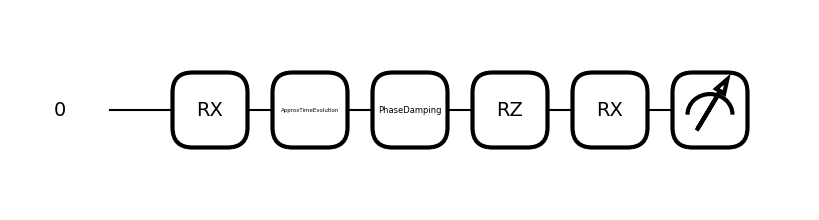

In [10]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [11]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [12]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 2 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

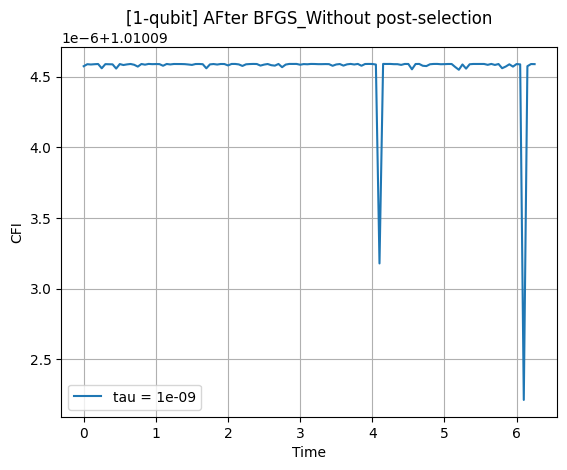

In [13]:
tau_plot = 1e-09,
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 5e-2])

Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for i in range(len(tau_plot)):
    Tau_global = tau_plot[i]
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = np.pi/2

    Gamma_ps_preset = 1e-2
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[i][:, 0] = Optimized_Result[1][:,2]
    Para_store[i][:, 1] = Optimized_Result[1][:,3]
    
    # plt.plot(Sweep_data_arange, Optimized_Result[0][:, 1], label = f'Before_tau = {tau_plot[i]}')
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, 1], label = f'tau = {tau_plot[i]}')
    plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
    
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

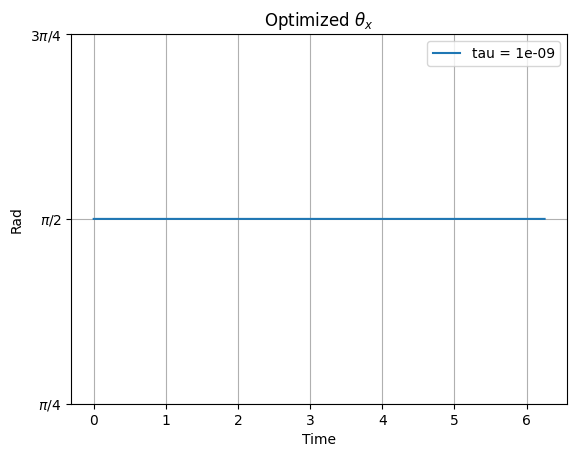

In [14]:
for i in range(0, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

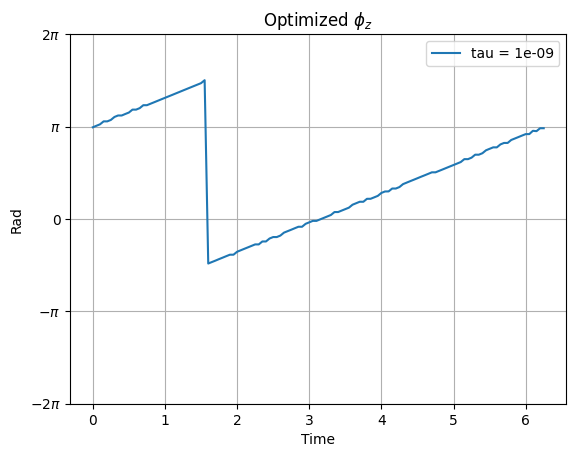

In [15]:
for i in range(0, len(tau_plot)):
    if i != 1:
        plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi], ['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [16]:
Para_store[0][:,0]

tensor([1.57079408, 1.57079732, 1.57079734, 1.570797  , 1.57079658,
        1.57079626, 1.5707965 , 1.57079752, 1.5707968 , 1.57079455,
        1.57079661, 1.57079633, 1.57079683, 1.57079584, 1.57079547,
        1.57079293, 1.57079676, 1.57079462, 1.57079629, 1.57079632,
        1.57079658, 1.57079623, 1.57079617, 1.57079649, 1.57079594,
        1.57079678, 1.570796  , 1.5707956 , 1.57079586, 1.57079616,
        1.57079685, 1.570796  , 1.57079649, 1.57079632, 1.57079624,
        1.57079596, 1.57079583, 1.57079511, 1.57079632, 1.57079634,
        1.57079398, 1.57079612, 1.57079632, 1.57079632, 1.57079398,
        1.57079761, 1.57079623, 1.57079623, 1.57079572, 1.57079714,
        1.57079474, 1.57079659, 1.57079634, 1.57079826, 1.57079657,
        1.57079632, 1.57079467, 1.57079653, 1.57079633, 1.57079635,
        1.57079577, 1.57079581, 1.57079585, 1.5707961 , 1.57079633,
        1.57079709, 1.57079538, 1.57079689, 1.57079681, 1.57079867,
        1.57079778, 1.57079632, 1.57079577, 1.57

In [17]:
Para_store[0][:,1]

tensor([ 3.11595044,  3.16674886,  3.21694582,  3.31703292,  3.31646985,
         3.36534497,  3.46650878,  3.51683151,  3.51624582,  3.56773873,
         3.61680076,  3.71616747,  3.71622577,  3.76660097,  3.86629328,
         3.86672737,  3.91671689,  3.96642444,  4.01660271,  4.06689045,
         4.11680752,  4.16634735,  4.21579408,  4.26648033,  4.31618936,
         4.36669324,  4.41643567,  4.46661937,  4.51636256,  4.56616397,
         4.6160329 ,  4.71661501, -1.51626207, -1.46670678, -1.41760894,
        -1.3660192 , -1.31654194, -1.26608652, -1.21655706, -1.21639844,
        -1.11668001, -1.06633259, -1.01631585, -0.96680891, -0.91690275,
        -0.8664246 , -0.86679456, -0.76645846, -0.76651939, -0.66566632,
        -0.61619686, -0.61673396, -0.56592337, -0.46584156, -0.41649026,
        -0.36744718, -0.31632151, -0.26639051, -0.26668086, -0.1664405 ,
        -0.11589818, -0.06622197, -0.06689431, -0.01650821,  0.03326072,
         0.08360556,  0.1335148 ,  0.23375497,  0.2

In [18]:
Optimized_Result

array([[[1.00000000e-04, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00],
        [5.01000000e-02, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00],
        [1.00100000e-01, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.15010000e+00, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00],
        [6.20010000e+00, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00],
        [6.25010000e+00, 9.99974746e-01, 1.57079633e+00, 1.57079633e+00]],

       [[1.00000000e-04, 1.01009457e+00, 1.57079408e+00, 3.11595044e+00],
        [5.01000000e-02, 1.01009459e+00, 1.57079732e+00, 3.16674886e+00],
        [1.00100000e-01, 1.01009458e+00, 1.57079734e+00, 3.21694582e+00],
        ...,
        [6.15010000e+00, 1.01009457e+00, 1.57079589e+00, 2.98428870e+00],
        [6.20010000e+00, 1.01009459e+00, 1.57079640e+00, 3.08380513e+00],
        [6.25010000e+00, 1.01009459e+00, 1.57079568e+00, 3.08360991e+00]]])